### Import 

In [286]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import seaborn as sns

In [384]:
import numpy as np
import pandas as pd
from scipy.stats import stats
from statistics import mean

In [288]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [289]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [290]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [291]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [292]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [293]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [294]:
# Create our session (link) from Python to the DB
session = Session(engine)
conn = engine.connect()

# Exploratory Data Analysis 

### Determine the column names and what values we have for each table

In [295]:
# Review the information in the Measurement table
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b7ee071dd8>,
 'date': '2010-01-01',
 'prcp': 0.08,
 'station': 'USC00519397',
 'id': 1,
 'tobs': 65.0}

In [296]:
# Review the information in the Station table
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1b78c9e8a20>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397'}

# Exploratory Climate Analysis

In [341]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = session.query(func.max(Measurement.date)).scalar()
# Calculate the date 1 year ago from the last data point in the database
# First get the latest date in the database
last_date

'2017-08-23'

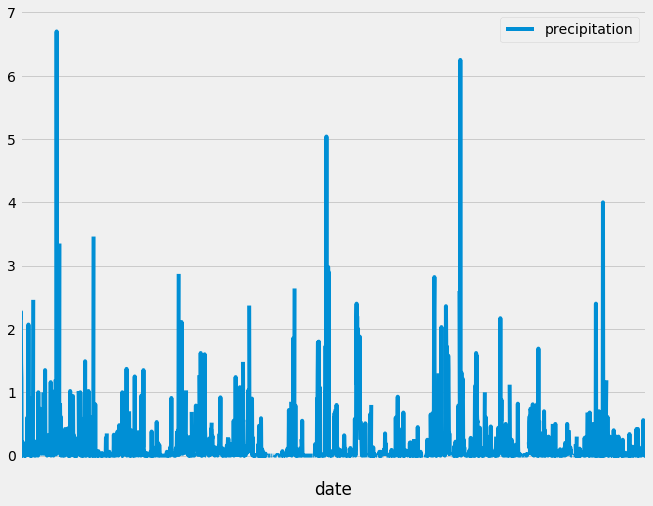

In [344]:
# Using the last date from above perform a query to retrieve the last 12 months of precipitation data
# and the dates and save query results as a Pandas Dataframe - using sqlalchemy method to get data
query_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

last_year = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()
df = pd.DataFrame(last_year)
# Set the index to the date column
df.set_index('date', inplace=True)
df.rename(columns = {'prcp':'precipitation'}, inplace = True) 
# Sort the dataframe by date
df.sort_index(inplace=True)

ax3 = df.plot(figsize=(10,8))
plt.xticks(ticks=[],labels=None)
plt.show()

### Alternative way than above using SQL statment instead of Sqlalchemy query object

In [345]:
# Using the last date from above perform a query to retrieve the last 12 months of precipitation data
# and the dates and save query results as a Pandas Dataframe - using a SQL query 
last_year = pd.read_sql("SELECT date,prcp FROM measurement where date >= DATE('2017-08-23','-12 month')", conn)

# Set the index to the date column
last_year.set_index('date', inplace=True)
last_year.rename(columns = {'prcp':'precipitation'}, inplace = True) 
# Sort the dataframe by date
last_year = last_year.sort_index()

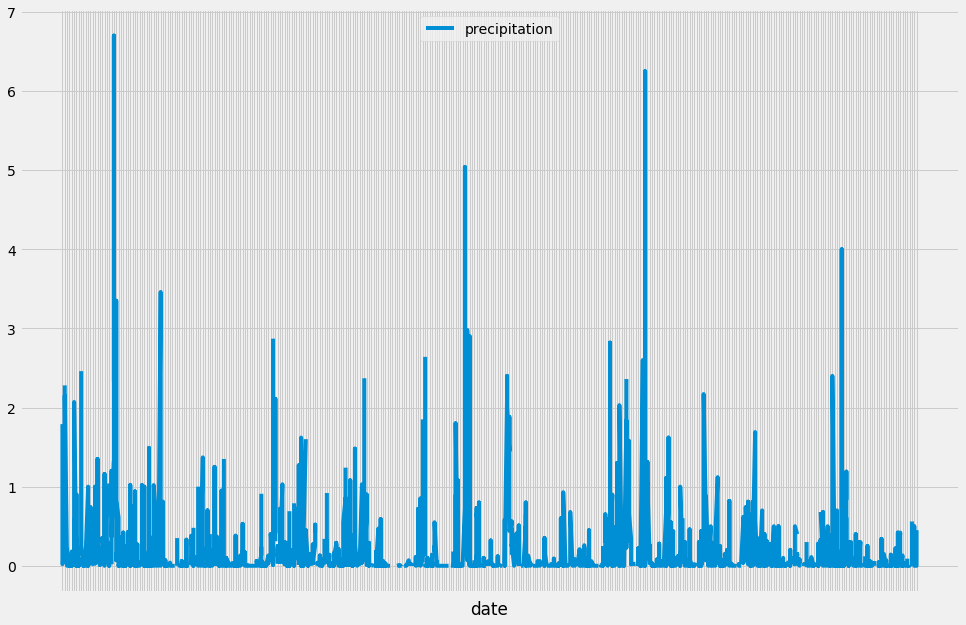

In [346]:
# Use Matplotlib to plot the data (just to get more detail and control)

# Create Figure and Axes instances
fig,ax = plt.subplots(1,figsize=(15,10))

# Make your plot, set your axes labels
ax.plot(last_year)
ax.set_xlabel('date')
ax.legend(['precipitation'],loc='upper center')

# Turn off tick labels since there are so many they will overwrite each other
ax.set_xticklabels([])
plt.savefig('Output/Precipitation.png')
plt.show()

In [347]:
# Use Pandas to calcualte the summary statistics for the precipitation data
last_year.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [348]:
# Design a query to show how many stations are available in this dataset?
num_stations = session.query(Station.station).\
                             group_by(Station.station).count()
print(f'The number of unique stations in this database is: {num_stations}')

The number of unique stations in this database is: 9


In [349]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active = session.query(Measurement.station,func.count(Measurement.station)).\
    filter(Station.station == Measurement.station).group_by(Measurement.station).\
    order_by(func.count(Station.station).desc()).all()
print('The following stations have the most rows in desc order:')
most_active

The following stations have the most rows in desc order:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [350]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
low_hi_avg = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),\
    func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()
low_hi_avg

[(54.0, 85.0, 71.66378066378067)]

In [351]:

most_temps = session.query(Measurement.station,func.count(Measurement.tobs)).\
    filter(Station.station == Measurement.station).filter(Measurement.tobs != None).group_by(Measurement.station).\
    order_by(func.count(Station.station).desc()).all()
most_temps

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [352]:
last_year_tobs = pd.read_sql("SELECT tobs FROM measurement where \
    station = 'USC00519281' AND date >= DATE('2017-08-23','-12 month')", conn)
last_year_tobs

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


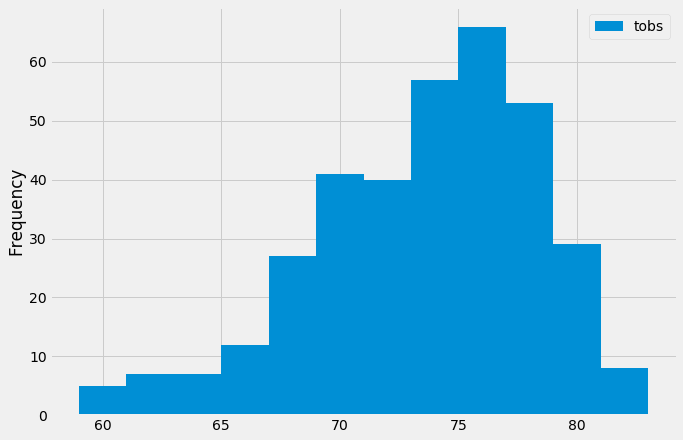

In [353]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station

last_year_tobs = pd.read_sql("SELECT tobs FROM measurement where \
    station = 'USC00519281' AND date >= DATE('2017-08-23','-12 month')", conn)

# Plot the results as a histogram

num_bins = 12
fig, ax = plt.subplots(figsize=(10,7))

n, bins, patches = ax.hist(last_year_tobs['tobs'], num_bins)

ax.set_ylabel('Frequency')
ax.legend(['tobs'],loc='best')

plt.savefig('Output/Histogram.png')
plt.show()

# Temperature Analysis I

### Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

In [358]:
# Determine the average temperature for June
june_temps = session.query(Measurement.tobs).\
        filter(Measurement.date.like("%-06-%")).all()
june_avg_temp = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.date.like("%-06-%")).scalar()
print(f"Avg June temp for all stations and all years is: {round(june_avg_temp,2)} F")

Avg June temp for all stations and all years is: 74.94 F


In [359]:
# Determine the average temperature for December
dec_temps = session.query(Measurement.tobs).\
        filter(Measurement.date.like("%-12-%")).all()
dec_avg_temp = session.query(func.avg(Measurement.tobs)).\
        filter(Measurement.date.like("%-12-%")).scalar()
print(f"Avg December temp for all stations and all years is: {round(dec_avg_temp,2)} F")

Avg December temp for all stations and all years is: 71.04 F


### Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?
A paired t-test will be used because the same thing is being measured multiple times.

In [396]:
# Generate function to do a t-test plot pair
def ttestplot(pop1, pop2):
    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(pop1)), pop1, label="pop1")
    plt.scatter(range(len(pop2)), pop2, label="pop2")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(pop1, 10, density=True, alpha=0.7, label="pop1")
    plt.hist(pop2, 10, density=True, alpha=0.7, label="pop2")
    plt.axvline(mean(pop1), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(mean(pop2), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  

In [397]:
june_temp_list = [item for t in june_temps for item in t] 
dec_temp_list = [item for t in dec_temps for item in t]

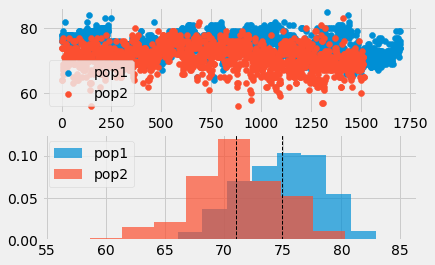

In [398]:
ttestplot(june_temp_list,dec_temp_list)

In [399]:
# Run a t-test between the June temps and Dec temps
stats.ttest_ind(june_temp_list,dec_temp_list, equal_var=False)

Ttest_indResult(statistic=31.355036920962423, pvalue=4.193529835915755e-187)

#### The t-test has a large F statistic AND a VERY SMALL p value so the June and December average temperatures are statistically different from one another.

In [ ]:
query_date = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
first_date = session.query(func.min(Measurement.date)).first().date
print(f"The first date in the db is: {first_date} and the last is: {last_date}")

In [ ]:
print(calc_temps(''))

# Temperature Analysis II

### Calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year 

* Plot the min, avg, and max temperature from your previous query as a bar chart.
* Use the average temperature as the bar height.
* Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [400]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [401]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# My trip dates are July 21 - July 31
min_avg_max = calc_temps('2017-02-22', '2017-03-01')
min_avg_max

[(61.0, 69.6923076923077, 77.0)]

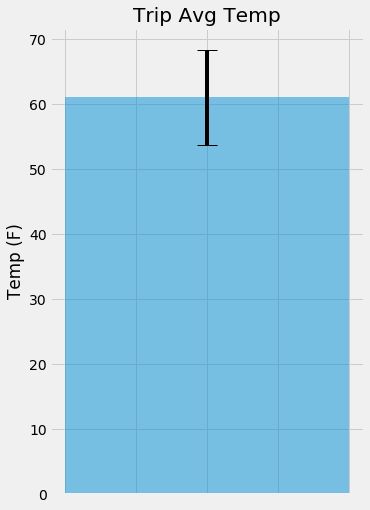

In [402]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).tavg, tmin, tmax = [min_avg_max[0][i] for i in (0,1,2)]

#Calculate the error
error = tmax - tmin

fig, ax = plt.subplots(figsize=(5,8))
ax.bar(1,tavg, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Temp (F)')
ax.set_xticklabels([])
ax.set_title('Trip Avg Temp')
ax.yaxis.grid(True)

# Save the figure and show
plt.savefig('Output/bar_plot_with_error_bars.png')
plt.show()

# Daily Rainfall Average

In [403]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_station = pd.read_sql("SELECT s.station,s.name,s.latitude,s.longitude,s.elevation,sum(m.prcp) as 'Total Rainfall'\
                            FROM station s\
                            JOIN measurement m ON(s.station = m.station)\
                            WHERE m.date BETWEEN '2017-02-22' AND '2017-03-01'\
                            GROUP BY s.station\
                            ORDER BY SUM(m.prcp) DESC" , conn)
rain_station.head(10)

,station,name,latitude,longitude,elevation,Total Rainfall
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,3.02
1,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9,2.57
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,2.42
3,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,2.22
4,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,1.29
5,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,1.27
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.72


# Daily Normals Calculations

In [436]:
# Create function that makes a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).first()
    
daily_normals("01-01")

(62.0, 69.15384615384616, 77.0)

In [437]:
# calculate the daily normals for your trip
# My trip dates again are: '02-22' Through'03-01'
trip_dates = ['02-22','02-23','02-24','02-25','02-26','02-27','02-28','03-01']

# push each tuple of calculations into a list called `normals`
# start with a blank list named normals
normals =[]

# Set the start and end date of the trip
# Use 'date' function to return the date without a time for our vacation start
start_vacation = dt.date(2018,2,22)
# Store the number of days of the vacation
numdays = 8

In [438]:
# Use a list comprehension to return the start date incremented by the increase in days
# cast the result as a string and slice it to return only from the 5th position (zero indexed) forward
# to yield a list of month-day values for each day of the vacation
date_list = [str(start_vacation + dt.timedelta(days=x))[5:] for x in range(numdays)]
print(date_list)

['02-22', '02-23', '02-24', '02-25', '02-26', '02-27', '02-28', '03-01']


In [439]:
# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(month_day) for month_day in date_list]
normals

[(60.0, 70.15789473684211, 83.0),
 (62.0, 70.35593220338983, 81.0),
 (61.0, 68.56666666666666, 76.0),
 (61.0, 68.59649122807018, 76.0),
 (62.0, 69.89285714285714, 78.0),
 (58.0, 69.98148148148148, 77.0),
 (65.0, 70.65517241379311, 80.0),
 (64.0, 70.0327868852459, 76.0)]

In [449]:
 # using list comprehension 
# convert list of tuples to list of list 
normals_list = [list(elements) for elements in normals]
normals_list

[[60.0, 70.15789473684211, 83.0],
 [62.0, 70.35593220338983, 81.0],
 [61.0, 68.56666666666666, 76.0],
 [61.0, 68.59649122807018, 76.0],
 [62.0, 69.89285714285714, 78.0],
 [58.0, 69.98148148148148, 77.0],
 [65.0, 70.65517241379311, 80.0],
 [64.0, 70.0327868852459, 76.0]]

In [456]:
#Load the list of daily normals into a Pandas DataFrame and set the index equal to the date.
df = pd.DataFrame(normals_list,index=date_list,columns=['tmin','tavg','tmax']).rename_axis('date')
df.head()

,tmin,tavg,tmax
date,,,
02-22,60.0,70.157895,83.0
02-23,62.0,70.355932,81.0
02-24,61.0,68.566667,76.0
02-25,61.0,68.596491,76.0
02-26,62.0,69.892857,78.0


In [ ]:
Use Pandas to plot an area plot (stacked=False) for the daily normals.

## scratch

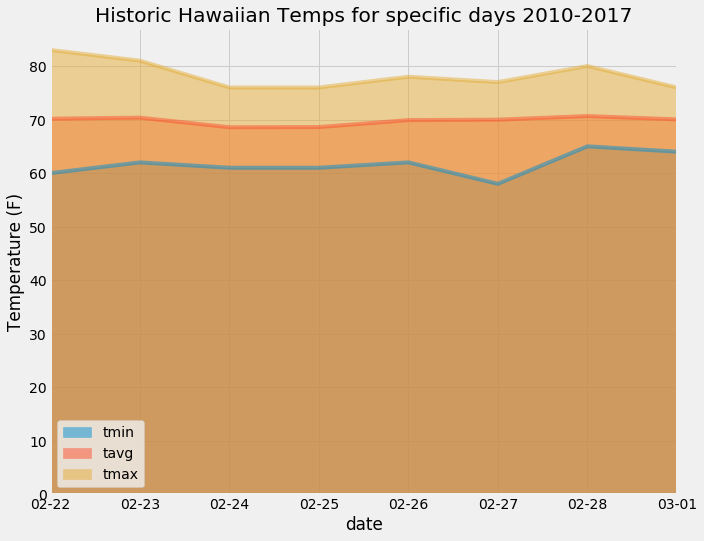

In [465]:
# Plot the daily normals as an area plot with `stacked=False`
ax = df.plot.area(figsize=(10,8),stacked=False)
plt.title('Historic Hawaiian Temps for specific days 2010-2017')
plt.ylabel('Temperature (F)')
plt.show()

#### Looks as though the average temperature in Hawaii for my vacation days is a perfect 70 degrees Fahrenheit!!